In [ ]:
# import torch
# import torchvision
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.autograd import Variable
# import torchvision.transforms as T
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt

# print('Czy mam CUDA?', torch.cuda.is_available() )
# x = torch.cuda.current_device()
# print('Nazwa GPU x:',torch.cuda.get_device_name(x))
# print('Wersja CUDNN:', torch.backends.cudnn.version())
# print('Ilość urządzeń CUDA:', torch.cuda.device_count())
# print('Nazwa urządzenia CUDA: ',torch.cuda.get_device_name(0))
# print('Pamięć urządzenia CUDA [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

# Metody inteligencji obliczeniowej - Sprawozdanie 4

# Zaawansowane sieci neuronowe. Sieci konwolucyjne

### Yuliya Zviarko, 08.04.25


# Wprowadzenie
Na kolejnych zajęciach przeszliśmy do tematu sieci konwolucyjnych (CNN), które stanowią rozszerzenie klasycznych sieci neuronowych i świetnie sprawdzają się w analizie danych „przestrzennych”.

## Co jest nie tak z najprostszą siecią MLP przy rozpoznawaniu obrazów?
Jeżeli za punkt wyjścia przyjąć zdjęcie zrobione typowym smartfonem, o rozdzielczości 1900 × 1600 pikseli, to daje to ponad 3 miliony wartości wejściowych. Gdyby spróbować podłączyć taki obraz do sieci neuronowej składającej się np. z dwóch warstw po 512 neuronów, liczba parametrów szybko osiąga gigantyczne wartości – mowa tu o dziesiątkach lub setkach milionów wag do wytrenowania.

Dodatkowo, klasyczne sieci gęste (MLP) wymagają przekształcenia danych wejściowych do postaci jednowymiarowego wektora. W przypadku obrazów oznacza to utratę informacji o lokalnym ułożeniu pikseli – czyli o strukturze obrazu. Przykładowo, drobne przesunięcie obiektu na obrazie, np. buta o kilka pikseli w górę, nie zmienia znaczenia zdjęcia dla człowieka, ale z punktu widzenia sieci MLP jest to już zupełnie inny zestaw danych.

Pojawia się więc potrzeba lepszego podejścia, które potrafi zachować lokalne zależności w obrazie – i tu właśnie wchodzą sieci konwolucyjne. Ich działanie można najlepiej zaobserwować podczas wykonywania zadania przewidzianego na bieżące laboratoria, którego przebieg został opisany poniżej.

# Przebieg laboratorium

# Zadanie 1
Zadanie pierwsze polegało na zaproponowaniu sieci konwolucyjnej do klasyfikacji popularnego zbioru Fashion MNIST, przygotowanego przez zespół Zalando.

Wymagane było zaprojektowanie co najmniej trzech różnych architektur, a dla każdej z nich należało przedstawić macierz pomyłek oraz wykresy funkcji straty z przebiegu uczenia.

Dodatkowo, w każdym przypadku należało pokazać przynajmniej jeden błędnie zaklasyfikowany obrazek.
$------------------------------------------------------$


Wstępnie musimy pobrać i przygotować nasz zbiór danych. Korzystając z biblioteki PyTorch, przygotowujemy wstępne przekształcenie obrazka na tensor oraz normalizujemy jego piksele do wartości z przedziału domkniętego $[-1,1]$.

Na zajęciach mieliśmy przykład z datasetem zawierającym cyfry (MNIST), natomiast w tym przypadku mamy do czynienia z obrazkami przedstawiającymi elementy garderoby. Obrazy są czarno-białe, więc każdy obraz posiada tylko jeden kanał.

Następnie określamy wielkość paczki, czyli liczbę obrazków, które będą ładowane jednocześnie podczas treningu. Wybrałam wartość 4, zgodnie z tym, co było pokazane we wstępie teoretycznym do laboratorium, choć jest to dość niska wartość (można ją później zmodyfikować w zależności od dostępnych zasobów sprzętowych).

Przygotowałam zbiór treningowy i przekształciłam go przy użyciu wcześniej zdefiniowanej transformacji. Dla tego zbioru utworzyłam także tzw. loader, czyli narzędzie do efektywnego ładowania danych w trakcie treningu modelu.
Analogiczne kroki wykonałam dla zbioru testowego, który posłuży do oceny jakości wytrenowanej sieci.


Na koniec zdefiniowałam nazwy klas, co pomoże w analizie uzyskanych wyników klasyfikacji i ich późniejszej interpretacji.

In [ ]:
import torch
import torchvision
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

batch_size = 4

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.69MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.6MB/s]


Kolejny krok mógłby zostać pominięty, jednak dla celów weryfikacji, korzystając z funkcji **imshow**, wyświetliłam losowo wybrane obrazki z naszego zbioru treningowego. Dla każdego obrazka poniżej wyświetliłam jego nazwę, korzystając ze wcześniej zdefiniowanej zmiennej classes.
Wszystko działa sprawnie, a na obrazkach mamy piękny pulower, buty, sukienkę i spodnie: 😊

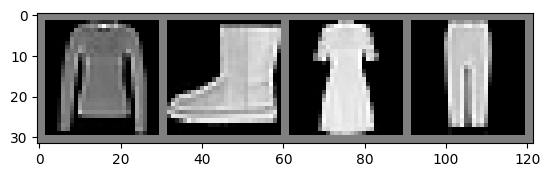

Pullover Ankle boot Dress Trouser


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # denormalizacja jest konieczna do wyświetlenia
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# znajdź losowe obrazki
dataiter = iter(trainloader)
images, labels = next(dataiter)

# wyświetl obrazki i ich podpisy
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


Kolejna i najważniejsza część – definiowanie sieci. Sieć pierwsza składa się z jednej warstwy konwolucyjnej o parametrach (1, 6, 5), co oznacza, że obraz, mający jeden kanał, jest przetwarzany przez 6 filtrów, a rozmiar każdego filtra (kernel) wynosi 5×5. Następnie stosowana jest warstwa pooling o parametrach (2, 2), czyli max pooling z oknem 2×2 i krokiem równym 2, co pozwala na redukcję rozmiarów map cech oraz zachowanie najważniejszych informacji. Kolejna warstwa konwolucyjna ma parametry (6, 16, 5); oznacza to, że pobiera ona 6 map cech z poprzedniej warstwy i generuje 16 map cech przy użyciu filtra o wymiarze 5×5. Ta druga warstwa umożliwia wykrycie bardziej złożonych cech obrazu, który przeszedł już przez pierwszy filtr i pooling.


Następnie pojawia się część sieci w postaci trzech warstw liniowych (fully connected). Pierwsza z nich przyjmuje wektor o wymiarze 16 * 4 * 4, czyli 256 elementów i przekształca go w wektor o 256 elementach. Ta warstwa uczy się łączenia wyekstrahowanych cech. Druga warstwa liniowa dokonuje dalszej redukcji danych, zmniejszając wymiar do 84. Ostatnia warstwa liniowa daje wyjście w postaci wektora 10 elementowego, gdzie każdy element odpowiada jednej z klas – "T-shirt/top", "Trouser" itd.


W metodzie forward definiowany jest sposób, w jaki dane przepływają przez kolejne warstwy sieci. Obrazek przechodzi najpierw przez pierwszą warstwę konwolucyjną, gdzie po zastosowaniu funkcji aktywacji ReLU następuje pooling, który zmniejsza rozmiar mapy cech. Podobnie wynik z tego kroku jest dalej poddawany drugiej konwolucji, funkcji aktywacji ReLU oraz kolejnemu poolingowi. Następnie zredukowany tensor jest spłaszczany do postaci wektora o wymiarze [batch_size, 256]. Ten wektor trafia kolejno do warstw liniowych – najpierw przetwarzany przez pierwszą warstwę z funkcją aktywacji ReLU, potem przez kolejną warstwę z ReLU, a na końcu przez ostatnią warstwę.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyCNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.linear1 = nn.Linear(16 * 4 * 4, 256)
        self.linear2 = nn.Linear(256, 84)
        self.linear3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

net1 = MyCNN1()

Kolejna sieć, MyCNN2, oparta jest na głębszej architekturze, która opiera się na trzech warstwach konwolucyjnych z paddingiem, które przetwarzają jednokanałowy obraz wejściowy, generując kolejno 16, 32, a następnie 64 map cech przy filtrach 3×3. Po każdej konwolucji stosowany jest max pooling (2×2, krok 2), redukujący rozmiary map, a po ostatnim bloku wprowadzony jest dropout (0.25) w celu przeciwdziałania przeuczeniu. Następnie wynikowe mapy o wymiarze 64×3×3 są spłaszczane i przekazywane do dwóch warstw liniowych – pierwsza zmniejsza wymiar do 128, a druga przekształca dane do ostatecznego wyjścia, czyli wektora o 10 elementach, odpowiadającego klasom badanego dataset'u.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyCNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net2 = MyCNN2()

Ostatnia sieć MyCNN3 wykorzystuje trzy warstwy konwolucyjne z paddingiem, każda uzupełniona o warstwę normalizacji wsadowej (BatchNorm), co stabilizuje uczenie. Pierwsza warstwa przekształca jednokanałowy obraz w 8 map cech, druga – 8 na 16, a trzecia – 16 na 32 mapy cech. Po każdej operacji konwolucji stosowany jest max pooling, który redukuje rozmiary map, a na końcu wynikowe mapy o wymiarze 32×3×3 są spłaszczane i przetwarzane przez dwie warstwy liniowe, gdzie pierwsza zmniejsza wymiar do 64, a druga generuje ostateczne wyjście w postaci wektora 10-elementowego.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyCNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net3 = MyCNN3()

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# Definicja funkcji straty i optymalizatorów
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)
optimizer3 = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)

# Funkcja trenowania modelu
def trenowanie(net, criterion, optimizer, epoki=5):
    straty = []
    for epoka in range(epoki):
        running_loss = 0.0
        for i, dane in enumerate(trainloader, 0):
            wejscia, etykiety = dane
            optimizer.zero_grad()
            wyjscia = net(wejscia)
            strata = criterion(wyjscia, etykiety)
            strata.backward()
            optimizer.step()
            running_loss += strata.item()
            if i % 2000 == 1999:
                print('[%d, %5d] strata: %.3f' % (epoka + 1, i + 1, running_loss / 2000))
                straty.append(running_loss / 2000)
                running_loss = 0.0
    print('Trenowanie zakończone')
    return straty

# Funkcja testowania modelu
def testowanie(net):
    poprawne = 0
    cale = 0
    macierz_pomyłek = np.zeros((10, 10), dtype=int)
    błędnie_sklasyfikowane_obrazki = []
    with torch.no_grad():
        for dane in testloader:
            obrazy, etykiety = dane
            wyjscia = net(obrazy)
            _, przewidywane = torch.max(wyjscia.data, 1)
            cale += etykiety.size(0)
            poprawne += (przewidywane == etykiety).sum().item()
            for i in range(len(etykiety)):
                macierz_pomyłek[etykiety[i]][przewidywane[i]] += 1
                if przewidywane[i] != etykiety[i] and len(błędnie_sklasyfikowane_obrazki) < 1:
                    błędnie_sklasyfikowane_obrazki.append((obrazy[i], etykiety[i], przewidywane[i]))

    print('Dokładność sieci na 10000 testowych obrazkach: %d %%' % (100 * poprawne / cale))
    print("Macierz pomyłek:")
    print(macierz_pomyłek)

    for idx, (obraz, prawdziwa_etykieta, przewidywana_etykieta) in enumerate(błędnie_sklasyfikowane_obrazki):
        print("Błędnie sklasyfikowany obrazek {}:".format(idx + 1))
        imshow(torchvision.utils.make_grid(obraz))
        print('Prawdziwa etykieta: {}'.format(classes[prawdziwa_etykieta]))
        print('Przewidywana etykieta: {}'.format(classes[przewidywana_etykieta]))
        plt.show()


In [ ]:
losses1 = train(net1, criterion, optimizer1, epochs=2)

[1,  2000] loss: 0.350
[1,  4000] loss: 0.342
[1,  6000] loss: 0.338
[1,  8000] loss: 0.326
[1, 10000] loss: 0.329
[1, 12000] loss: 0.323
[1, 14000] loss: 0.313
[2,  2000] loss: 0.289
[2,  4000] loss: 0.311
[2,  6000] loss: 0.311
[2,  8000] loss: 0.304
[2, 10000] loss: 0.306
[2, 12000] loss: 0.306
[2, 14000] loss: 0.299
Finished Training


In [ ]:
losses2 = train(net2, criterion, optimizer2, epochs=2)


[1,  2000] loss: 0.332
[1,  4000] loss: 0.323
[1,  6000] loss: 0.315
[1,  8000] loss: 0.320
[1, 10000] loss: 0.306
[1, 12000] loss: 0.299
[1, 14000] loss: 0.299
[2,  2000] loss: 0.276
[2,  4000] loss: 0.296
[2,  6000] loss: 0.282
[2,  8000] loss: 0.280
[2, 10000] loss: 0.282
[2, 12000] loss: 0.284
[2, 14000] loss: 0.263
Finished Training


In [ ]:
losses3 = train(net3, criterion, optimizer3, epochs=2)

[1,  2000] loss: 0.275
[1,  4000] loss: 0.260
[1,  6000] loss: 0.268
[1,  8000] loss: 0.272
[1, 10000] loss: 0.295
[1, 12000] loss: 0.267
[1, 14000] loss: 0.271
[2,  2000] loss: 0.247
[2,  4000] loss: 0.253
[2,  6000] loss: 0.255
[2,  8000] loss: 0.254
[2, 10000] loss: 0.251
[2, 12000] loss: 0.259
[2, 14000] loss: 0.244
Finished Training


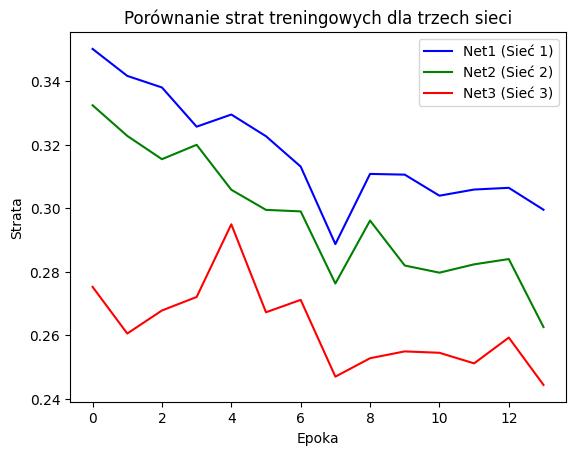

In [ ]:
plt.plot(losses1, label='Net1 (Sieć 1)', color='blue')
plt.plot(losses2, label='Net2 (Sieć 2)', color='green')
plt.plot(losses3, label='Net3 (Sieć 3)', color='red')

plt.title('Porównanie strat treningowych dla trzech sieci')
plt.xlabel('Epoka')
plt.ylabel('Strata')

plt.legend()
plt.show()

Sieć 1 zaczyna z wysoką stratą, ale stopniowo poprawia wyniki, osiągając stabilizację na poziomie 0.299 na końcu. Prawdopodobnie jest potrzeba dodania większej liczby epok lub innych optymalizacji wewnątrz sieci, aby uzyskać lepsze wyniki, szczególnie w okolicach 6-8 epoki.

Sieć 2 ma najszybszy i najbardziej równomierny spadek strat, co wskazuje na skuteczniejszy proces uczenia. Jej końcowa strata (0.263) jest lepsza od Sieci 1.

Sieć 3, mimo że zaczyna z niższą stratą, wykazuje pewną niestabilność w trakcie treningu. Jednak osiąga najniższą końcową stratę (0.244), co sugeruje, że może być najskuteczniejsza, mimo że jej wyniki są mniej stabilne niż w Sieci 2.


Tendencja wyników Sieci 2 podoba mi się bardziej, ponieważ widać rzeczywisty proces uczenia się, a jej strata jest bliska tej z Sieci 3, która ma najniższy wynik.

Accuracy of the network on the 10000 test images: 87 %
Confusion Matrix:
[[771   0  12   8   6   0 184   0  19   0]
 [  0 978   0  14   2   0   3   0   3   0]
 [ 14   0 808   8  95   0  70   0   5   0]
 [ 51  10  11 797  73   0  51   0   7   0]
 [  1   1  69  16 861   0  47   0   5   0]
 [  0   0   0   0   0 976   0  16   0   8]
 [ 94   2  71   9 118   0 686   0  20   0]
 [  0   0   0   0   0  29   0 942   2  27]
 [  2   2   2   0   5   4   1   4 980   0]
 [  0   0   0   0   0   8   0  38   1 953]]
Misclassified Image 1:


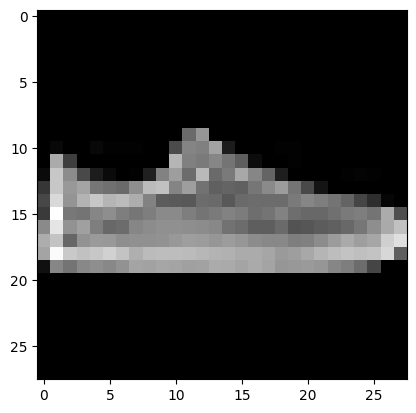

True Label: Sneaker
Predicted Label: Sandal
Accuracy of the network on the 10000 test images: 88 %
Confusion Matrix:
[[921   0  15  24   3   1  29   0   7   0]
 [  3 980   0  14   1   0   1   0   1   0]
 [ 21   2 861  14  68   0  33   0   1   0]
 [ 32  11  10 908  20   0  17   0   1   1]
 [  3   2  89  40 834   0  31   0   1   0]
 [  0   0   0   0   0 970   0  19   5   6]
 [223   2 119  32 123   0 489   0  12   0]
 [  0   0   0   0   0  14   0 960   0  26]
 [  4   1   2   5   3   2   2   4 977   0]
 [  0   0   0   0   0   6   0  32   1 961]]
Misclassified Image 1:


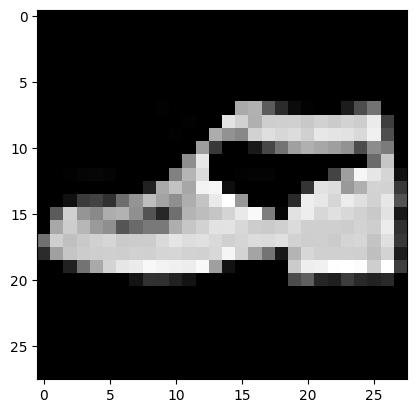

True Label: Ankle boot
Predicted Label: Sandal
Accuracy of the network on the 10000 test images: 90 %
Confusion Matrix:
[[803   1  15  36   4   2 128   0  11   0]
 [  1 980   0  12   3   0   2   0   2   0]
 [ 10   1 812   8  86   0  82   0   1   0]
 [  7   5   5 940  17   0  25   0   1   0]
 [  0   0  47  35 873   0  43   0   2   0]
 [  0   0   0   0   0 985   0   7   2   6]
 [ 72   3  55  35 121   0 707   0   7   0]
 [  0   0   0   0   0  13   0 974   1  12]
 [  3   1   1   4   4   3   1   3 980   0]
 [  0   0   0   0   0  11   0  43   0 946]]
Misclassified Image 1:


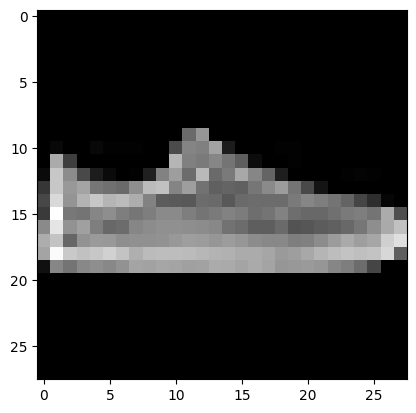

True Label: Sneaker
Predicted Label: Bag


In [ ]:
test(net1)
test(net2)
test(net3)

Sieć 1 osiągnęła dokładność na poziomie 87%. Model skutecznie klasyfikuje większość klas, ale niektóre błędy są zauważalne: np. klasyfikacja "Sneaker" jako "Sandal".
Mimo to, ogólny wynik wskazuje na przyzwoitą wydajność modelu.

Sieć 2 osiągnęła dokładność na poziomie 88%, co stanowi o 1% lepszy wynik niż sieć 1. Model osiąga dobre wyniki w większości klas, jednak podobnie jak w przypadku sieci 1, nadal występują pewne błędy, takie jak klasyfikacja "Ankle boot" jako "Sandal".

Sieć 3, z dokładnością 90%, osiągnęła najlepszy wynik spośród trzech modeli. Jest to najlepszy model w klasyfikacji, choć nadal pojawiają się błędy, takie jak klasyfikacja "Sneaker" jako "Bag", co w tych przypadkach wydaje się być najpoważniejszym błędem i może budzić pewne wątpliwości 🥸. Pomimo pewnej niestabilności w treningu, sieć 3 charakteryzuje się najwyższą skutecznością i najniższą liczbą błędów w porównaniu z pozostałymi modelami.

Wszystkie sieci poprawiają swoje wyniki w miarę upływu epok. Wybierałabym między siecią 2 a siecią 3, bazując na wykresach "Porównanie strat treningowych dla trzech sieci".

# Zadanie 2

Dla jednej wybranej architektury, proszę porównać czas uczenia sieci na CPU i na GPU, do czego mogą Państwo wykorzystać własną kartę NVidii lub zasoby Colaba. W Runtime->Change Runtime Type musi być zaznaczona opcja "T4 GPU".

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
import torchvision

device_cpu = torch.device("cpu")

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

batch_size = 128

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

class MyCNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net2_cpu = MyCNN2().to(device_cpu)

criterion = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(net2_cpu.parameters(), lr=0.001, momentum=0.9)

def trenowanie_cpu(net, criterion, optimizer, epoki=5):
    straty = []
    for epoka in range(epoki):
        running_loss = 0.0
        for i, dane in enumerate(trainloader, 0):
            wejscia, etykiety = dane
            wejscia, etykiety = wejscia.to(device_cpu), etykiety.to(device_cpu)
            optimizer.zero_grad()
            wyjscia = net(wejscia)
            strata = criterion(wyjscia, etykiety)
            strata.backward()
            optimizer.step()
            running_loss += strata.item()
            if i % 2000 == 1999:
                print('[%d, %5d] strata: %.3f' % (epoka + 1, i + 1, running_loss / 2000))
                straty.append(running_loss / 2000)
                running_loss = 0.0
    print('Trenowanie zakończone')
    return straty

def mierzenie_czasu_na_treningu_cpu(net, criterion, optimizer, epoki=5):
    start_time = time.time()
    trenowanie_cpu(net, criterion, optimizer, epoki)
    end_time = time.time()
    return end_time - start_time

print("Czas treningu na CPU:")
czas_cpu = mierzenie_czasu_na_treningu_cpu(net2_cpu, criterion, optimizer2, epoki=2)
print(f"Czas treningu na CPU: {czas_cpu} sekund.")


Czas treningu na CPU:
Trenowanie zakończone
Czas treningu na CPU: 98.92982411384583 sekund.


In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
import torchvision

device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

batch_size = 128

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

class MyCNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net2_gpu = MyCNN2().to(device_gpu)

criterion = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(net2_gpu.parameters(), lr=0.001, momentum=0.9)

def trenowanie_gpu(net, criterion, optimizer, epoki=5):
    straty = []
    for epoka in range(epoki):
        running_loss = 0.0
        for i, dane in enumerate(trainloader, 0):
            wejscia, etykiety = dane
            wejscia, etykiety = wejscia.to(device_gpu), etykiety.to(device_gpu)
            optimizer.zero_grad()
            wyjscia = net(wejscia)
            strata = criterion(wyjscia, etykiety)
            strata.backward()
            optimizer.step()
            running_loss += strata.item()
            if i % 2000 == 1999:
                print('[%d, %5d] strata: %.3f' % (epoka + 1, i + 1, running_loss / 2000))
                straty.append(running_loss / 2000)
                running_loss = 0.0
    print('Trenowanie zakończone')
    return straty

def testowanie_gpu(net):
    poprawne = 0
    cale = 0
    macierz_pomyłek = np.zeros((10, 10), dtype=int)
    błędnie_sklasyfikowane_obrazki = []
    with torch.no_grad():
        for dane in testloader:
            obrazy, etykiety = dane
            obrazy, etykiety = obrazy.to(device_gpu), etykiety.to(device_gpu)
            wyjscia = net(obrazy)
            _, przewidywane = torch.max(wyjscia.data, 1)
            cale += etykiety.size(0)
            poprawne += (przewidywane == etykiety).sum().item()
            for i in range(len(etykiety)):
                macierz_pomyłek[etykiety[i]][przewidywane[i]] += 1
                if przewidywane[i] != etykiety[i] and len(błędnie_sklasyfikowane_obrazki) < 1:
                    błędnie_sklasyfikowane_obrazki.append((obrazy[i], etykiety[i], przewidywane[i]))

    print('Dokładność sieci na 10000 testowych obrazkach: %d %%' % (100 * poprawne / cale))
    print("Macierz pomyłek:")
    print(macierz_pomyłek)

    for idx, (obraz, prawdziwa_etykieta, przewidywana_etykieta) in enumerate(błędnie_sklasyfikowane_obrazki):
        print("Błędnie sklasyfikowany obrazek {}:".format(idx + 1))
        imshow(torchvision.utils.make_grid(obraz))
        print('Prawdziwa etykieta: {}'.format(classes[prawdziwa_etykieta]))
        print('Przewidywana etykieta: {}'.format(classes[przewidywana_etykieta]))
        plt.show()

def mierzenie_czasu_na_treningu_gpu(net, criterion, optimizer, epoki=5):
    start_time = time.time()
    trenowanie_gpu(net, criterion, optimizer, epoki)
    end_time = time.time()
    return end_time - start_time

print("Czas treningu na GPU:")
czas_gpu = mierzenie_czasu_na_treningu_gpu(net2_gpu, criterion, optimizer2, epoki=2)
print(f"Czas treningu na GPU: {czas_gpu} sekund.")


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.19MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.6MB/s]


Czas treningu na GPU:
Trenowanie zakończone
Czas treningu na GPU: 23.795994758605957 sekund.


Na początku testu przyjmujemy założenie[https://www.spiceworks.com/tech/hardware/articles/cpu-vs-gpu/], że CPU to uniwersalny procesor, a GPU to wyspecjalizowany procesor zoptymalizowany do obliczeń matematycznych, idealny do grafiki komputerowej i uczenia maszynowego. Testy potwierdzają to założenie: czas treningu na CPU wyniósł 98.93 sekundy, a na GPU 23.80 sekundy. GPU, dzięki większej liczbie rdzeni obliczeniowych i optymalizacji do obliczeń równoległych, przyspiesza proces treningu w zadaniach związanych z deep learningiem, co pozwala na znaczne oszczędności czasu... zwłaszcza gdy pisze się sprawozdanie o pierwszej w nocy.

